### **STEP ONE** OF DATA PROCESSING PIPELINE

##### This script imports data in which a Reliable Component Analysis was performed. Visual Stimulus was dual frequency tagged: 2F1 = 6 Hz, 2F2 = 7.5 Hz (inverting stim). Each participant completed 2 sessions. For each session, a xF1 and xF2 bandpass filter was performed. So 1 single participant has 4 data files. This is for a frequency-based analysis of the LTP paradigm

In [161]:
# load packages
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
from itertools import chain

### Set Dynamic Params

In [162]:
rca_comp = 0 # rca component to look at 
harmo = 1 # harmonic to look at 0-3 : 2, 4,6,8

### Set Dir Path(s): MainDir, SaveDataDir

In [163]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_Fx_OutputData\\RCA_Files\\' # set dir - on my computer
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Avilable Files to choose from: {len(d)}')
print(f'Files on hand: {d}')
##############################################
FileN_f1 = d[1] # choose one
FileN_f2  = d[3]                         
file_path1 = os.path.join(MainDir, FileN_f1) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

file_path2 = os.path.join(MainDir, FileN_f2) # join paths and prep 2 load
print('Current WD:',file_path2) # does path exist ... ?
print('Does File #2 Exist?',os.path.exists(file_path1)) # yes or no

Avilable Files to choose from: 5
Files on hand: ['desktop.ini', 'OfficialF1_Control_rcaResults_Sweep.mat', 'OfficialF1_rcaResults_Sweep_F2F4F6F8.mat', 'OfficialF2_Control_rcaResults_Sweep.mat', 'OfficialF2_rcaResults_Sweep_F2F4F6F8.mat']
Current WD: C:\plimon\LTP_analysis\RCA_Fx_OutputData\RCA_Files\OfficialF1_Control_rcaResults_Sweep.mat
Does File #1 Exist? True
Current WD: C:\plimon\LTP_analysis\RCA_Fx_OutputData\RCA_Files\OfficialF2_Control_rcaResults_Sweep.mat
Does File #2 Exist? True


In [164]:
# # Save Data Dir ...
# #SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AllSubjSweepRCA\\' # set dir where files (.pkl, .csv) will be saved
# SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\' # set dir where files (.pkl, .csv) will be saved
# FileOutName = 'AllSessionDataCombin_allHarms' 
# newPath = os.path.join(SaveDataDir, FileOutName)
# if not os.path.exists(SaveDataDir):
#     os.makedirs(SaveDataDir)
# print(f'Path to save data:{SaveDataDir}')
# ######################################################
# dnt = datetime.now() # add date and time bc im wreckless when saving ..
# fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
# FileN = f'{FileOutName}_{fdnt}.pkl' 
# #FileNToMatlab = f'{FileOutName}_{fdnt}.h5' 
# #FileN = f'{FileOutName}_{fdnt}.csv' 
# NewFileNPath = os.path.join(SaveDataDir,FileN)
# print('Full New File Dir: ', NewFileNPath)

### load all data per file

In [165]:
df_f1 = scipy.io.loadmat(file_path1)
df_f2 = scipy.io.loadmat(file_path2)

#### Load F1 and F2 RCA Data

In [166]:
rca_f1 = df_f1['rcaResult']['projectedData'][0,0]
f1 = [rca_f1[x,0] for x in range(rca_f1.shape[0])] # entry per subject

In [167]:
rca_f2 = df_f2['rcaResult']['projectedData'][0,0]
f2 = [rca_f2[x,0] for x in range(rca_f2.shape[0])]

In [168]:
# load subject names ...
SubNames = df_f1['rcaResult'][0,0][5]
FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]]
print(f'Total Data Files: {len(FileName)}')

Total Data Files: 10


In [169]:
str_split = '-'  # strong to index sub name and expt cond.
labels = ['Potentiated Stim, Attention Congruent','Non-Potentiated Stim, Attention Congruent','No Stim, Attention Incongruent, F1 ','No Stim, Attention Incongruent, F2']
#labels = ['A-I C','A-I Control','~A-I','A-I INC']
contrast_labs = ['1%','3%','5%','16%','40%','100%']
# custom colors
colors = ["#FF0B04", "#4374B3", "#228B22", "#8A2BE2"]
# Set color palette
sns.set_palette(sns.color_palette(colors))

#### Make Subj Session Name Format Uniform and extract sub ID 

In [170]:
# set all file names to the same hyphen format
FileName = [FileName.replace('_','-') for FileName in FileName]
NumFiles = int(len(FileName))
# Find How Many Subject Names There are ...
string_ind = '-'
uniqueSubs = []
SessFileType = []
'for each file name, get sub ID and also session record'
for n in range(NumFiles):
    x = FileName[n] # single file name string ie: 'nl-xxxx_attnX'
    if string_ind in x:
        y = x.split(string_ind)[0] # get subj number
        #print(y)
        z = x.split(string_ind)[1] # get session condition name 
        #print(z)
        # from each session name extract import info that will help us index and exclude later on ..
        uniqueSubs.append(y) # store all participant numbers (repeating - will be sorted later)
        SessFileType.append(z) # store the condtion label

### If running control group, unhashtag this line of code VVV

In [171]:
subjLen  = int(len(uniqueSubs))
SessFileType = ['attnR' for _ in range(subjLen)]
print(SessFileType)

['attnR', 'attnR', 'attnR', 'attnR', 'attnR', 'attnR', 'attnR', 'attnR', 'attnR', 'attnR']


In [172]:
print(f'Subject IDs: {uniqueSubs}')
print(f' Conditions: {SessFileType[0:2]}')

Subject IDs: ['2738', '2740', '2742', '2745', '2746', '2751', '2769', '345202', '345215', '345216']
 Conditions: ['attnR', 'attnR']


In [173]:
# given double sessions.., how many unique participants do we have?
TotalFiles = np.array(uniqueSubs)
[NumSubs, SessCounts] = np.unique(TotalFiles, return_counts = True) # returns unique subject and how many sessions they did (should be 2)
print(f'Total Participants: {len(NumSubs)}')
[FileQuants, TotSess] = np.unique(SessCounts, return_counts = True) # returns counts of how many subs did 1 session and 2 sessions 

Total Participants: 10


In [174]:
TwoSess = SessCounts == 2 # index of who completed 2 sessions ..
GoodSubjs = NumSubs[TwoSess] # subs who completed 2 sessions 
SingleSessSubjs = NumSubs[~TwoSess] # subs who did not complete 2 sessions 

In [175]:
SingleSubs = SingleSessSubjs
print(SingleSessSubjs)

['2738' '2740' '2742' '2745' '2746' '2751' '2769' '345202' '345215'
 '345216']


#### Have to add this step because I ran someone for attnR **twice** ... yikes ...

In [176]:
# # makes sure paticipants did complete attnL and attnR
# FNameCrit = ['attnL', 'attnR'] # session names 
# CleanSubjs = []

# for i in range(len(GoodSubjs)):
#     subj = GoodSubjs[i]
#     f_list = [x for x in FileName if subj in x] # import all strongs were sub number is 
#     list_check  = np.sort(f_list) # abc order strings -  attnL and THEN attnR
#     #print(list_check)
#     print(list_check)
#     counter = 0
#     for n in range(len(FNameCrit)):
#         if FNameCrit[n] in list_check[n]: # expt label should match file name in same position
#             counter = counter + 1 # if so add 1 
#             if (n == 1) and (counter == 2): # if both files strings are different, append
#                 CleanSubjs.append(GoodSubjs[i])
#         else: # if not, add em to the singletons ... 
#             print(f'{GoodSubjs[i]} did not match file name for {FNameCrit[n]}, moving subj to proper file ind array')
#             str_nm = (np.array([GoodSubjs[i]], dtype=object))
#             SingleSubs = np.concatenate((str_nm, SingleSessSubjs))

### If there is a specific group of subjects to look at, here is where subj ID's can be grouped

In [177]:
#dataSet_Inds = ['2651','2658','2659','2661','2664','2666','2668','2672','2674','2695','345202','345215','2715','2726']
ds_set =SingleSubs
print(len(ds_set))
#dubSubs = ['2652']
# for control subjects: 
'subject 2749 has one additional block of post, so will modify code for this chunk only'
badSubs = ['2745', '345215'] 
# for LTP Subjects
#badSubs = ['2661','2669','2671','2716','2663','2652'] # reasonable exclusions...
#badSubs = ['2652','2663','2655','2657','2661','2668','2669','2671','2696','2660','2678','2627'] # most conservative ec : activity across all conditions decreased and/or very noisy crf's 
filter_noisySubs = [x for x in ds_set if x not in badSubs ]
dataSet_Inds = filter_noisySubs
print(len(dataSet_Inds))

10
8


In [178]:
# total number of file sessions!
sCount = [x for x in uniqueSubs if x not in badSubs]
print(len(sCount))

8


#### How many participants **actually** completed single control sessions:

In [179]:
print(f'{len(SingleSubs)} Participants completed control session')

10 Participants completed control session


### Plot CRF for set harmonic index, per rca component selected

In [180]:
'init dicts to save data'
ProcessedConditionData = {} # pcd processed condition data
diffs = {} # post - pre  / post + pre data
ProcessedComplexVals = {}
####################################################
'make empty df for missing values to still get plots'
emptyMat = np.zeros((48,4,78))
emptyMat[:] = np.nan

###################################################
for sIn in range(len(dataSet_Inds)):
    'initialize subkeys for data'
    ProcessedConditionData[sIn] = {} # pcd processed condition data
    diffs[sIn] = {} # post - pre  / post + pre data
    ProcessedComplexVals[sIn] = {} # init dict to store real and imaginary values for data

    'enter subj ID to find file locations'
    All_Data_sIn = dataSet_Inds[sIn]
    print(f'importing subject {All_Data_sIn}s data')
    SubjFile_Pos = [(i, x) for i, x in enumerate(FileName) if All_Data_sIn in x]

    #print(SubjFile_Pos)
    fx_fileInds = np.array([SubjFile_Pos[0][0]]) # FILE POSITION
    #SessionCond = SubjFile_Pos[0][1] # FILE NAME
    print(fx_fileInds)

    print(f'AttnR File Pos: {fx_fileInds}, Exp Session: attnR')
            # set data set to plot w filler data
    DuoSessionData = [emptyMat,emptyMat,f1[fx_fileInds[0]], f2[fx_fileInds[0]]]


    'iterate thorugh all conditions, see *labels* above'
    for datamat in range(4): 

        x = np.array(DuoSessionData[datamat])
        # look at first RCA component
        xf = x[:,rca_comp,:] # [48 x 78] 1f1 2f1 4f1 6f1

        cols,rows = xf.shape # get dims of data  
        col_index = int(cols/2) # real and imaginary values to divide
        row_index = int(rows/2) # pre post boundries to divide 
        ComplexData = np.zeros((2,col_index,rows)) #real/imag x contrast/harmonic vals x trials

        #print(ComplexData.shape)
        realData= xf[0:col_index,:] # real values for all trials 
        phaseData = xf[col_index:,:] # imaginary values for all trials

        'store data in a more organized array (reshape)'
        ComplexData[0,:,:] = realData
        ComplexData[1,:,:] = phaseData

        harmonicData = {}
        'harmonic epochs indicies'
        HamronicIndicies = np.arange(0,col_index,6) # index to get 
        'index data to prep for further processing'
        for j in range(4):
            s = HamronicIndicies[j]
            e = s+6
            harmonicData[j] = ComplexData[:,s:e,:]  #[2 x 6 x ~80 ]

        'pre allocate for crf and complex values'   
        #complexValues = {} # no combination of real x imaginary
        #CleanCRF = {} # contrast response functions
        'pre post differnces per harmonic'
        pp_diff = np.zeros((4,6)) 

        'import harmonic data per datamatrix in data set as pre post'

        for l in range(4):
            cplxValsRec = np.zeros((2,2,6)) # pre/postx real/imaginary values x per contrast sweep incriment
            crfValsRec = np.zeros((2,6))

            'import data per harmonic'
            hd = harmonicData[l] # 2 x 6 x numtrials
            'split pre/post'
            p1 = hd[:,:,:row_index] # pre  [2x6xnumtrials]
            p2 = hd[:,:,row_index:] # post 
            'store pre post in temp set array'
            px_set = [p1,p2] # store pre post in temp array

            for pp in range(2):
                dIn = px_set[pp] # import pre or post data [2x6,~39]
                for sweep in range(6): # import data for 1 contrast only [2x39]
                    avgVal = dIn[:,sweep,:] # 2 x 39 vals
                    av = np.nanmean(avgVal,axis = 1) #[2]
                    'pre/post x contrast values ][2 x 6]'
                    crfValsRec[pp,sweep] = np.hypot(av[0],av[1]) # pre / post contrast response functions
                    cplxValsRec[pp,:,sweep] = av #[2x2xx6] # pre/posr x real/imaginary values x contrast sweep inc

            pp_diff[l,:] = (crfValsRec[1,:] - crfValsRec[0,:]) / (crfValsRec[0,:] + crfValsRec[1,:]) # post - pre response differences

            ProcessedConditionData[sIn,datamat,l] = crfValsRec
            diffs[sIn,datamat] = pp_diff
            ProcessedComplexVals[sIn,datamat,l] = cplxValsRec

importing subject 2738s data
[0]
AttnR File Pos: [0], Exp Session: attnR
importing subject 2740s data
[1]
AttnR File Pos: [1], Exp Session: attnR
importing subject 2742s data
[2]
AttnR File Pos: [2], Exp Session: attnR
importing subject 2746s data
[4]
AttnR File Pos: [4], Exp Session: attnR
importing subject 2751s data
[5]
AttnR File Pos: [5], Exp Session: attnR
importing subject 2769s data
[6]
AttnR File Pos: [6], Exp Session: attnR
importing subject 345202s data
[7]
AttnR File Pos: [7], Exp Session: attnR
importing subject 345216s data
[9]
AttnR File Pos: [9], Exp Session: attnR


C:\Users\plimon\AppData\Local\Temp\ipykernel_32536\2830394152.py:85: RuntimeWarning: Mean of empty slice
  av = np.nanmean(avgVal,axis = 1) #[2]


C:\Users\plimon\AppData\Local\Temp\ipykernel_32536\3900625283.py:20: RuntimeWarning: Mean of empty slice
  avgs = np.nanmean(diffs_dataSet,axis = (1))
C:\Users\plimon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


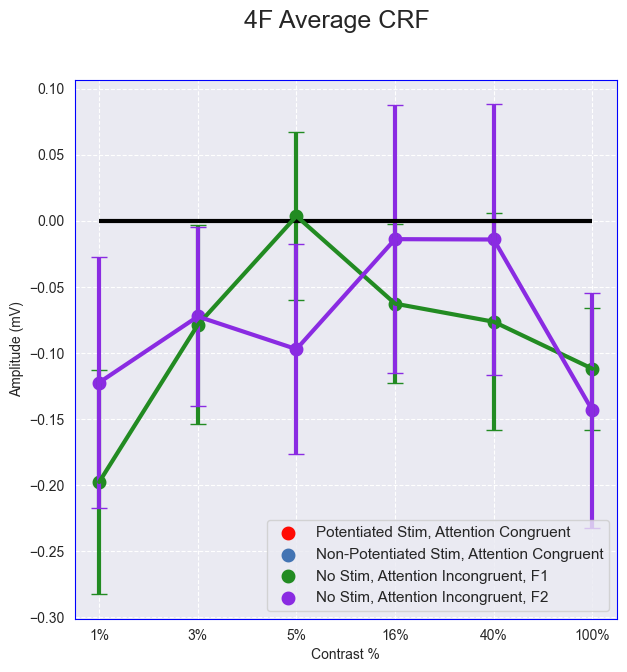

In [181]:
custom = {"axes.edgecolor": "blue", "grid.linestyle": "dashed", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)
dsi = int(len(dataSet_Inds))
diffs_dataSet = np.zeros((4,dsi,6))
# harmo  = 0
harmoincC = ['2F','4F','6F','8F']

fig,axs = plt.subplots(figsize = (7,7), squeeze=True)
plt.suptitle(f'{harmoincC[harmo]} Average CRF', fontsize = 18)
#axs.set_ylim([-0.150,0.150])

'find srqt of subject size'
sqr_root = np.sqrt(dsi)


for fi_co in range(4):
    for subjIn in range(len(dataSet_Inds)):
        diffs_dataSet[fi_co,subjIn,:] = diffs[subjIn,fi_co][harmo,:]

avgs = np.nanmean(diffs_dataSet,axis = (1))
stds = (np.nanstd(diffs_dataSet,axis = (1))) / sqr_root

for i in range(4):
    # axs.plot(avgs[i,:], linewidth = 4, label = labels[i], color = colors[i])
    axs.scatter(np.arange(0,6,1), avgs[i,:], linewidth = 4, label = labels[i], color = colors[i])
    #if i == 0 or i == 3:
    axs.errorbar(x = np.arange(0,6,1),y = avgs[i,:], yerr = stds[i,:], color = colors[i], capsize=6, linewidth = 3) # fmt = 'o'
    axs.legend(loc = 'lower right', fontsize = 11)
axs.set_ylabel(f'Amplitude (mV)')
axs.set_xlabel(f'Contrast %')
axs.set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
axs.hlines(0,xmin = 0 , xmax = 5, color = 'black', linewidth = 3)



In [182]:
'here is where data will be combined, regardless of Atten-Induction Cong/Incong'
ssrp_Diffs_All_F1 = np.zeros((dsi*2,6)) # get attn Induct Cong data
ssrp_Diffs_All_F2 = np.zeros((dsi*2,6)) # get attn Induct Cong data
# diffs[subject data, conditions 1-4] [harmonic, contrast data]

for sub in range(dsi):
    F1_combs = np.zeros((2,6)) # store F1 data for both sessions
    F2_combs = np.zeros_like(F1_combs) # store F2 data from both sessions 

    'attention induction congruent data flies'
    F1_aic = diffs[sub,0][harmo,:] # F1 induction (ai congruent)
    F2_aicntrl = diffs[sub,1][harmo,:] # F2  (control)
    'attention-induction incongruent data files'
    F1_aiincntrl= diffs[sub,2][harmo,:] # F1 induction (ai-incongruent)
    F2_aiinc = diffs[sub,3][harmo,:]# F2 

    F1_combs[0,:] = F1_aic
    F1_combs[1,:] = F1_aiincntrl

    F2_combs[0,:] = F2_aicntrl
    F2_combs[1,:] = F2_aiinc

    ssrp_Diffs_All_F1[sub:sub+2,:] = F1_combs
    ssrp_Diffs_All_F2[sub:sub+2,:] = F2_combs


In [183]:
print(ssrp_Diffs_All_F1.shape)

f1_m = np.nanmean(ssrp_Diffs_All_F1,axis = 0)
f2_m = np.nanmean(ssrp_Diffs_All_F2,axis = 0)

stds_F1 = (np.nanstd(ssrp_Diffs_All_F1,axis = (0))) / sqr_root
stds_F2 = (np.nanstd(ssrp_Diffs_All_F2,axis = (0))) / sqr_root


(16, 6)


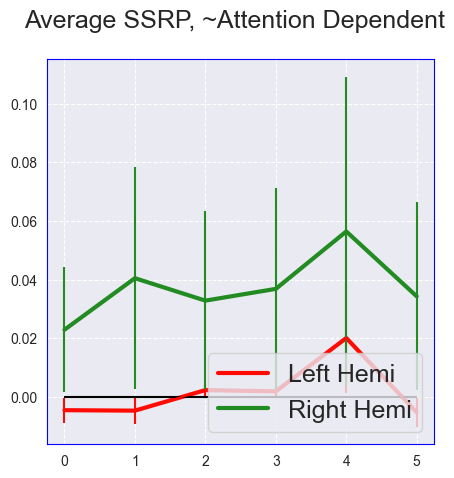

In [184]:
fig,axs = plt.subplots(figsize = (5,5), squeeze=True)
plt.suptitle(f'Average SSRP, ~Attention Dependent', fontsize  = 18)

axs.plot(f1_m, color = colors[0], label = 'Left Hemi', linewidth = 3)
axs.errorbar(x = np.arange(0,6,1),y = f1_m, yerr = stds_F1,  color = colors[0])


axs.plot(f2_m, color = colors[2], label = 'Right Hemi', linewidth = 3)
axs.errorbar(x = np.arange(0,6,1),y = f2_m, yerr = stds_F2, color = colors[2])


axs.hlines(0,xmin = 0,xmax = 5, color = 'black')
axs.legend(loc = 'lower right', fontsize = 18)

In [185]:
# sn = 10
# F1_combs = np.zeros((2,6))
# F2_combs = np.zeros_like(F1_combs)

# 'attention induction congruent data flies'
# F1_aic = diffs[sn,0][harmo,:] # F1 induction (ai congruent)
# F2_aicntrl = diffs[sn,1][harmo,:] # F2  (control)
# 'attention-induction incongruent data files'
# F1_aiincntrl= diffs[sn,2][harmo,:] # F1 induction (ai-incongruent)
# F2_aiinc = diffs[sn,3][harmo,:]# F2 

# F1_combs[0,:] = F1_aic
# F1_combs[1,:] = F1_aiincntrl

# F2_combs[0,:] = F2_aicntrl
# F2_combs[1,:] = F2_aiinc

#### Save Data into .pkl file

In [186]:
# dataOut = {}

# dataOut[0] = SessDataOut
# dataOut[1] = SingleSessDataOut

In [187]:
saveFile = 'n'

if saveFile == 'y':
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(dataOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    print('Sorted Data Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Did Not Save File! Change file name before switching to y!
